In [2]:
import io,os, random, operator, sys
from collections import Counter
import random
import numpy as np
import collections
import math
import sys
from util import *
import matplotlib.pyplot as plt

## 一些功能函数
需要阅读这些函数来对实验中用到的数据结构，步骤有一些理解

In [3]:
def dotProduct(d1, d2):
    """
    @param dict d1: a feature vector represented by a mapping from a feature (string) to a weight (float).
    @param dict d2: same as d1
    @return float: the dot product between d1 and d2
    """
    if len(d1) < len(d2):
        return dotProduct(d2, d1)
    else:
        return sum(d1.get(f, 0) * v for f, v in d2.items())


In [4]:
def increment(d1, scale, d2):
    """
    Implements d1 += scale * d2 for sparse vectors.
    @param dict d1: the feature vector which is mutated.
    @param float scale
    @param dict d2: a feature vector.
    """
    for f, v in d2.items():
        d1[f] = d1.get(f, 0) + v * scale


In [5]:
def readExamples(path):
    '''
    读取数据
    '''
    examples = []
    for line in open(path, encoding = "ISO-8859-1"):
        # Format of each line: <output label (+1 or -1)> <input sentence>
        y, x = line.split(' ', 1)
        examples.append((x.strip(), int(y)))
    print('Read %d examples from %s' % (len(examples), path))
    return examples


In [6]:
def evaluatePredictor(examples, predictor):
    '''
    在|examples|上测试|predictor|的性能，返回错误率
    '''
    error = 0
    for x, y in examples:
        if predictor(x) != y:
            error += 1
    return 1.0 * error / len(examples)

## Feature extrator (Your codes here)

### (1) 使用BOW作为特征
(a) 复习BOW
(b) 如何把一个句子（字符串）转化成BOW的特征？

In [7]:
def extractFeatures_bow(x):
    features = collections.defaultdict(float)
    for word in x.split():
        features[word] += 1.0
    return features

### (2) 使用N-Gram作为特征
(a) 复习N-Gram相关的内容
(b) 字级别N-Gram还是词语级别？
(c) 如何把一个句子（字符串）转化成N-Gram的特征？

In [8]:
def extractFeatures_ngram(x, n=2):
    features = collections.defaultdict(float)
    words = x.split()
    for i in range(len(words) - n + 1):
        ngram = ' '.join(words[i:i+n])
        features[ngram] += 1.0
    return features

### （3） 使用word2vec作为特征
(a) 获得词向量。你可以借鉴第一次的作业，使用gensim来自己训练一个word2vec, 或者加载预训练过的word2vec(gensim的网站上有说明如何下载并使用预训练过的词向量)。
(b) 考虑如何使用词向量得到句子的表示向量（feature）。
(c) 将向量转化为其余部分可以处理的形式（如：dict）
(d) 考虑如何**更好地**使用词向量得到句子的表示向量（feature）。

提示: 在ipynb的代码块中可以使用! 来执行命令行中的命令, 例如
```
!pip install gensim
```

In [9]:
# 使用预训练的word2vec模型(FastText Word Embeddings)加载词向量 

def loadWord2VecModel(filename):
    wordVectors = {}
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            wordVectors[word] = vector
    return wordVectors

In [10]:
wiki_news= './data/wiki-news-300d-1M.vec'
wordVectors = loadWord2VecModel(wiki_news)

In [11]:
def extractFeatures_wordvec(x):
    # 将句子x拆分成单个字符或单词
    tokens = x.split()
    # 句子的词向量表示
    vectors = [wordVectors[token] for token in tokens if token in wordVectors.keys()]
    # 将句子中的每个单词转换为对应的词向量，然后将这些词向量的平均值作为该句子的特征向量
    if vectors:
        # 将句子中的每个单词转换为对应的词向量，然后将这些词向量的平均值作为该句子的特征向量
        vectors = np.mean(vectors, axis=0)
    else:
        # 处理句子中所有单词都不在模型中的情况
        vectors = np.zeros(len(next(iter(wordVectors.values()))))
    # 将特征向量表示为字典
    featureDict = {}
    for i, value in enumerate(vectors):
        featureDict[f'feature_{i}'] = value
    
    return featureDict

### (4) Test your feature extractor
实现了特征提取函数之后，可以简单地测试输出的正确性

In [12]:
sentence = "a truly wonderful tale combined with stunning animation ."
extractFeatures_bow(sentence)

defaultdict(float,
            {'a': 1.0,
             'truly': 1.0,
             'wonderful': 1.0,
             'tale': 1.0,
             'combined': 1.0,
             'with': 1.0,
             'stunning': 1.0,
             'animation': 1.0,
             '.': 1.0})

In [13]:
extractFeatures_ngram(sentence)

defaultdict(float,
            {'a truly': 1.0,
             'truly wonderful': 1.0,
             'wonderful tale': 1.0,
             'tale combined': 1.0,
             'combined with': 1.0,
             'with stunning': 1.0,
             'stunning animation': 1.0,
             'animation .': 1.0})

In [14]:
extractFeatures_wordvec(sentence)

{'feature_0': -0.015788889,
 'feature_1': -0.031044444,
 'feature_2': -0.037788887,
 'feature_3': -0.022766666,
 'feature_4': 0.008255554,
 'feature_5': -0.04491111,
 'feature_6': -0.0072111106,
 'feature_7': -0.0014666673,
 'feature_8': -0.016855557,
 'feature_9': 0.008622223,
 'feature_10': -0.015466667,
 'feature_11': -0.033733334,
 'feature_12': -0.0752,
 'feature_13': -0.029000001,
 'feature_14': 0.05194444,
 'feature_15': -0.0050777774,
 'feature_16': 0.03831111,
 'feature_17': -0.036411114,
 'feature_18': -0.052144445,
 'feature_19': -0.01168889,
 'feature_20': -0.05437778,
 'feature_21': 0.026044445,
 'feature_22': 0.018011112,
 'feature_23': 0.051777776,
 'feature_24': 0.0025777784,
 'feature_25': -0.0508,
 'feature_26': 0.014877778,
 'feature_27': -0.052522223,
 'feature_28': 0.0066111083,
 'feature_29': -0.024466665,
 'feature_30': -0.013599998,
 'feature_31': -0.023655554,
 'feature_32': 0.051422223,
 'feature_33': -0.016577778,
 'feature_34': 0.060577776,
 'feature_35': 0.

## 学习与梯度更新
你需要理解题目中的loss_function, 自行推导出weights的更新公式，
通过对训练集上样本的迭代，来更新weights

In [15]:
def learnPredictor(trainExamples, testExamples, featureExtractor, numIters, eta):
    '''
    给定训练数据和测试数据，特征提取器|featureExtractor|、训练轮数|numIters|和学习率|eta|，
    返回学习后的权重weights
    你需要实现随机梯度下降优化权重
    '''
    weights = collections.defaultdict(float)
    trainErrors = []
    testErrors = []
    trainLosses = []
    testLosses = []

    for i in range(numIters):
        totalTrainLoss = 0
        totalTestLoss = 0

        for x, y in trainExamples:
            featureVector = featureExtractor(x)
            predicted = dotProduct(featureVector, weights)
            loss = max(0, 1 - predicted * y)
            totalTrainLoss += loss
            if loss > 0:
                for feature, value in featureVector.items():
                    weights[feature] += eta * value * y

        for x, y in testExamples:
            featureVector = featureExtractor(x)
            predicted = dotProduct(featureVector, weights)
            loss = max(0, 1 - predicted * y)
            totalTestLoss += loss

        trainError = evaluatePredictor(trainExamples, lambda x: (1 if dotProduct(featureExtractor(x), weights) >= 0 else -1))
        testError = evaluatePredictor(testExamples, lambda x: (1 if dotProduct(featureExtractor(x), weights) >= 0 else -1))

        trainErrors.append(trainError)
        testErrors.append(testError)
        trainLosses.append(totalTrainLoss / len(trainExamples))
        testLosses.append(totalTestLoss / len(testExamples))

        print("At iteration %d, loss on training set is %f, loss on test set is %f, error rate on training set is %f, error rate on test set is %f" %
              (i, totalTrainLoss / len(trainExamples), totalTestLoss / len(testExamples), trainError, testError))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(numIters), trainLosses, label="Train Loss")
    plt.plot(range(numIters), testLosses, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs. Epoch")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(numIters), trainErrors, label="Train Error Rate")
    plt.plot(range(numIters), testErrors, label="Test Error Rate")
    plt.xlabel("Epoch")
    plt.ylabel("Error Rate")
    plt.title("Error Rate vs. Epoch")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return weights

## 已经定义好的训练测试流程

Read 3554 examples from data/data_rt.train
Read 3554 examples from data/data_rt.test
At iteration 0, loss on training set is 0.889153, loss on test set is 0.788351, error rate on training set is 0.289814, error rate on test set is 0.350872
At iteration 1, loss on training set is 0.698160, loss on test set is 0.742600, error rate on training set is 0.217220, error rate on test set is 0.323579
At iteration 2, loss on training set is 0.591522, loss on test set is 0.729116, error rate on training set is 0.180923, error rate on test set is 0.310355
At iteration 3, loss on training set is 0.515636, loss on test set is 0.701080, error rate on training set is 0.146877, error rate on test set is 0.298818
At iteration 4, loss on training set is 0.456052, loss on test set is 0.688303, error rate on training set is 0.125492, error rate on test set is 0.291503
At iteration 5, loss on training set is 0.407752, loss on test set is 0.670858, error rate on training set is 0.105796, error rate on test s

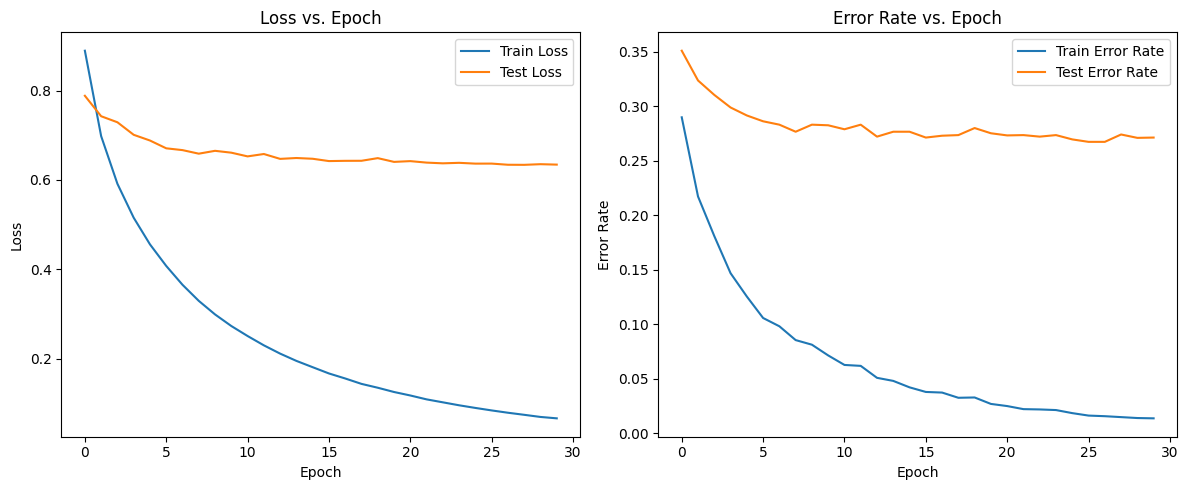

train error = 0.013787281935846933, test error = 0.27124366910523356


In [16]:
def BOW_Model(numIters, eta):
    trainExamples = readExamples('data/data_rt.train')
    testExamples = readExamples('data/data_rt.test')
    featureExtractor = extractFeatures_bow
    weights = learnPredictor(trainExamples, testExamples, featureExtractor, numIters=numIters, eta=eta)
    trainError = evaluatePredictor(trainExamples, lambda x : (1 if dotProduct(featureExtractor(x), weights) >= 0 else -1))
    testError = evaluatePredictor(testExamples, lambda x : (1 if dotProduct(featureExtractor(x), weights) >= 0 else -1))
    print ("train error = %s, test error = %s" % (trainError, testError))

BOW_Model(30, 0.01)

Read 3554 examples from data/data_rt.train
Read 3554 examples from data/data_rt.test
At iteration 0, loss on training set is 0.961806, loss on test set is 0.931097, error rate on training set is 0.136185, error rate on test set is 0.370568
At iteration 1, loss on training set is 0.717122, loss on test set is 0.884803, error rate on training set is 0.090321, error rate on test set is 0.364378
At iteration 2, loss on training set is 0.528393, loss on test set is 0.859609, error rate on training set is 0.046145, error rate on test set is 0.353405
At iteration 3, loss on training set is 0.385661, loss on test set is 0.844887, error rate on training set is 0.020259, error rate on test set is 0.338210
At iteration 4, loss on training set is 0.281044, loss on test set is 0.835757, error rate on training set is 0.014069, error rate on test set is 0.332864
At iteration 5, loss on training set is 0.208540, loss on test set is 0.829519, error rate on training set is 0.009848, error rate on test s

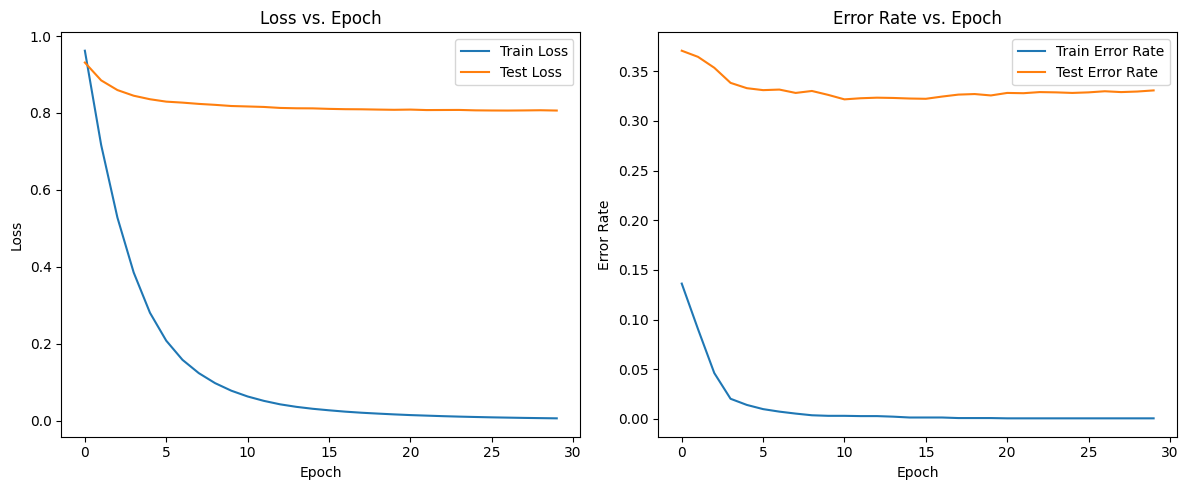

train error = 0.0005627462014631402, test error = 0.33061339335959483


In [17]:
def Ngram_Model(numIters, eta):
    trainExamples = readExamples('data/data_rt.train')
    testExamples = readExamples('data/data_rt.test')
    featureExtractor = extractFeatures_ngram
    weights = learnPredictor(trainExamples, testExamples, featureExtractor, numIters=numIters, eta=eta)
    trainError = evaluatePredictor(trainExamples, lambda x : (1 if dotProduct(featureExtractor(x), weights) >= 0 else -1))
    testError = evaluatePredictor(testExamples, lambda x : (1 if dotProduct(featureExtractor(x), weights) >= 0 else -1))
    print ("train error = %s, test error = %s" % (trainError, testError))

Ngram_Model(30, 0.01)

## 测试你的模型!
(a) 超参请自行更改
(b) 自行增加代码来进行训练loss和测试loss变化图的绘制
(b) 分析性能,模型泛化能力, 权重weights的可解释性等等

Read 3554 examples from data/data_rt.train
Read 3554 examples from data/data_rt.test
At iteration 0, loss on training set is 0.983132, loss on test set is 0.952660, error rate on training set is 0.472425, error rate on test set is 0.470737
At iteration 1, loss on training set is 0.936246, loss on test set is 0.907135, error rate on training set is 0.440912, error rate on test set is 0.446258
At iteration 2, loss on training set is 0.890496, loss on test set is 0.866554, error rate on training set is 0.315419, error rate on test set is 0.321891
At iteration 3, loss on training set is 0.848406, loss on test set is 0.827863, error rate on training set is 0.284750, error rate on test set is 0.290377
At iteration 4, loss on training set is 0.809947, loss on test set is 0.792879, error rate on training set is 0.284187, error rate on test set is 0.289533
At iteration 5, loss on training set is 0.775536, loss on test set is 0.763929, error rate on training set is 0.280248, error rate on test s

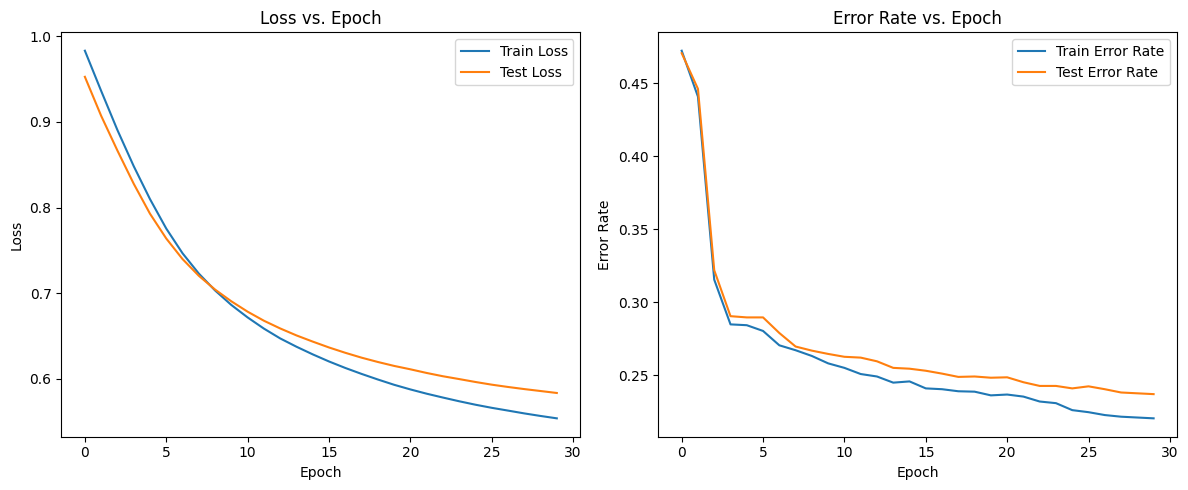

train error = 0.22031513787281937, test error = 0.236916150815982


In [18]:
def Word2Vec_Model(numIters, eta):
    trainExamples = readExamples('data/data_rt.train')
    testExamples = readExamples('data/data_rt.test')
    featureExtractor = extractFeatures_wordvec
    weights = learnPredictor(trainExamples, testExamples, featureExtractor, numIters=numIters, eta=eta)
    trainError = evaluatePredictor(trainExamples, lambda x : (1 if dotProduct(featureExtractor(x), weights) >= 0 else -1))
    testError = evaluatePredictor(testExamples, lambda x : (1 if dotProduct(featureExtractor(x), weights) >= 0 else -1))
    print ("train error = %s, test error = %s" % (trainError, testError))

Word2Vec_Model(30, 0.01)